In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
HF_HUB_DISABLE_SYMLINKS_WARNING=1
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [139]:
MAX_LENGTH = 64
BATCH_SIZE = 32
EPOCHS = 10

### Explore Data

In [7]:
train_df = pd.read_csv("train.csv")

In [9]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [13]:
train_df.fillna(".",inplace=True)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27481 non-null  object
 2   selected_text  27481 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [17]:
def sentiment_to_numbers(x):
    if x =="neutral":
        return 1
    elif x =="negative":
        return 0
    return 2
train_df["sentiment"] = train_df["sentiment"].apply(sentiment_to_numbers)

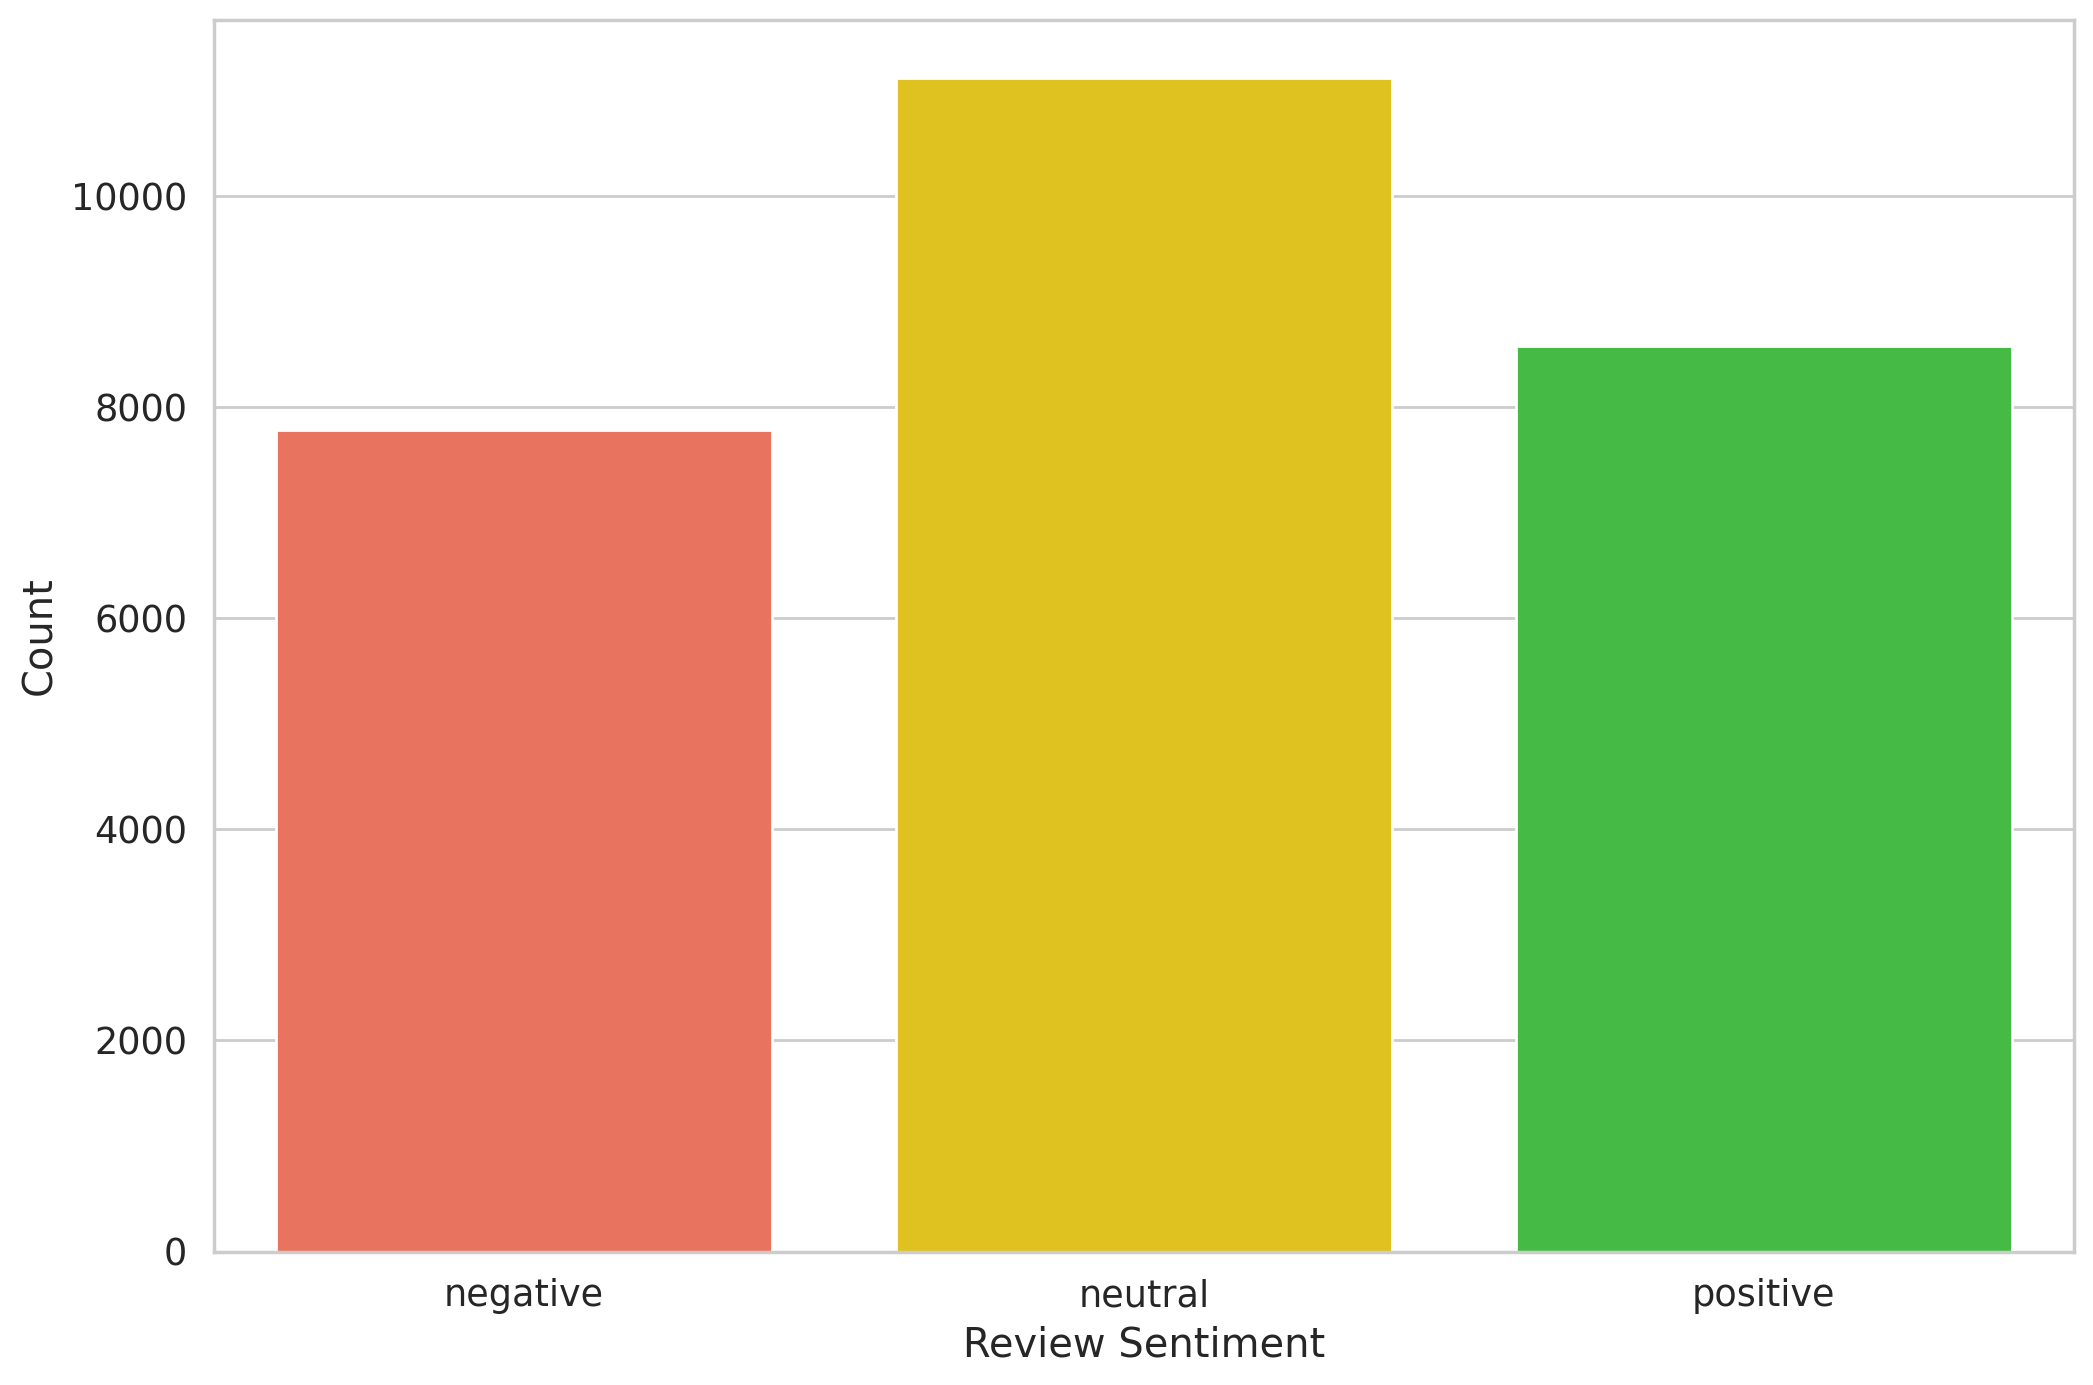

In [75]:
class_names = ['negative', 'neutral', 'positive']


colors = ['#FF6347', '#FFD700', '#32CD32']  

ax = sns.countplot(data=train_df, x="sentiment", hue="sentiment", palette=colors, legend=False)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(class_names)

plt.xlabel('Review Sentiment')
plt.ylabel('Count')

plt.show()

### Data Preprocessing

In [21]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer  = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [25]:
sample_txt = 'Hello World. Does this is beautiful day? '

In [27]:
tokens = tokenizer.tokenize(sample_txt)

In [29]:
print(tokens)

['Hello', 'World', '.', 'Does', 'this', 'is', 'beautiful', 'day', '?']


In [31]:
tokens_ids = tokenizer.convert_tokens_to_ids(tokens)

In [33]:
print(tokens_ids)

[8667, 1291, 119, 7187, 1142, 1110, 2712, 1285, 136]


In [35]:
print(f"Sentence : {sample_txt}")
print(f"Tokenize Sentence : {tokens}")
print(f"Tokens IDs: {tokens_ids}")

Sentence : Hello World. Does this is beautiful day? 
Tokenize Sentence : ['Hello', 'World', '.', 'Does', 'this', 'is', 'beautiful', 'day', '?']
Tokens IDs: [8667, 1291, 119, 7187, 1142, 1110, 2712, 1285, 136]


### Special Tokens

In [38]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [40]:
tokenizer.cls_token , tokenizer.cls_token_id

('[CLS]', 101)

In [42]:
tokenizer.pad_token , tokenizer.pad_token_id

('[PAD]', 0)

In [44]:
tokenizer.unk_token , tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, 
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  
)
encoding.keys()

In [48]:
encoding["input_ids"]

tensor([[ 101, 8667, 1291,  119, 7187, 1142, 1110, 2712, 1285,  136,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [50]:
len(encoding["input_ids"][0])

32

In [52]:
encoding["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

### Choosing Sequence Length

In [55]:
token_lens = []
for txt in train_df["text"]:
    tokens = tokenizer.encode(txt,max_length=512)
    token_lens.append(len(tokens))
    

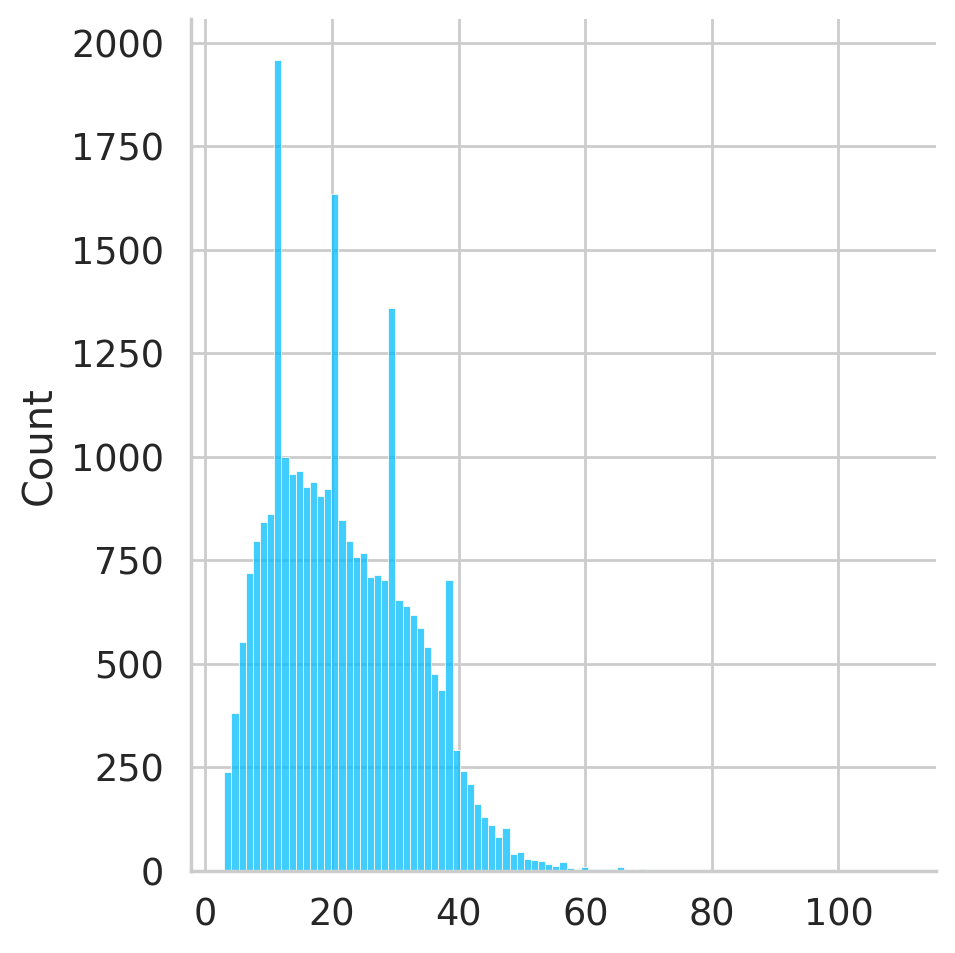

In [56]:
sns.displot(token_lens)

### Create Dataset

In [91]:
class Twit_Dataset(Dataset):
    def __init__(self,twits,targets,tokenizer,max_length):
        self.twits = twits
        self.targets = targets
        self.tokenizer  = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.twits)
    def __getitem__(self,index):
        twit = str(self.twits[index])
        target = self.targets[index]
    
        encoding = self.tokenizer.encode_plus(
          twit,
          add_special_tokens=True,
          max_length=self.max_length,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
    
        return {
          'twits_text': twit,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [206]:
df_train, df_val = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED)

In [208]:
df_train.shape

(24732, 4)

In [212]:
df_val.shape

(2749, 4)

In [214]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = Twit_Dataset(
        twits=df.selected_text.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_length= max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [216]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE)


In [103]:
data = next(iter(train_data_loader))
data.keys()

/home/svyatoslav/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['twits_text', 'input_ids', 'attention_mask', 'targets'])

In [105]:
print(data["twits_text"][0],data["targets"][0])

WTF facebook just cleared out my whole survey and i was on the last q, this night gets better and better  what else is next? tensor(2)


In [107]:
encoding["input_ids"]

tensor([[ 101, 8667, 1291,  119, 7187, 1142, 1110, 2712, 1285,  136,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [109]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [111]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict = False)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [112]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [115]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [117]:
bert_model.config.hidden_size

768

### Building a Sentiment Classifier

In [119]:
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict = False)
        self.drop = nn.Dropout(p = 0.3)
        self.out  = nn.Linear(bert_model.config.hidden_size,n_classes)
        self.softmax  = nn.Softmax(dim=1)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)
        
        

In [121]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [123]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) 
print(attention_mask.shape)

torch.Size([16, 64])
torch.Size([16, 64])


In [125]:
input_ids

tensor([[  101,   160, 22169,  ...,     0,     0,     0],
        [  101,  3056,  1122,  ...,     0,     0,     0],
        [  101,   178,  1631,  ...,     0,     0,     0],
        ...,
        [  101, 22797,   106,  ...,     0,     0,     0],
        [  101,  5871, 10582,  ...,     0,     0,     0],
        [  101,  2816,   102,  ...,     0,     0,     0]], device='cuda:0')

In [127]:
attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [129]:
model(input_ids,attention_mask)

tensor([[-0.4811, -0.0793,  0.8709],
        [-0.0665, -0.5822,  0.8265],
        [-0.5304,  0.3273,  1.2737],
        [-0.7563, -0.0628,  0.9995],
        [-0.4705,  0.1736,  1.0448],
        [-0.9226,  0.1979,  1.2159],
        [ 0.1878,  0.2558,  0.9520],
        [-0.1371,  0.1190,  0.2893],
        [-0.2822,  0.2502,  0.2999],
        [-0.2612, -0.1151,  0.8611],
        [-0.4523, -0.3956,  1.4626],
        [-0.4080,  0.3540,  0.4705],
        [-0.6175,  0.2806,  0.8288],
        [ 0.0383,  0.0501,  0.5311],
        [-0.9713, -0.2663,  0.6218],
        [-0.2662,  0.0267,  1.0003]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### Training

In [131]:
optimizer = optim.AdamW(model.parameters(),lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [133]:
def train_epoch (
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        outputs = model(
            input_ids=input_ids,
          attention_mask=attention_mask
        )
        _,pred = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        
        correct_predictions+=torch.sum(pred == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples , np.mean(losses)
        
    

In [190]:
def eval_model(model,data_loader,loss_fn,device,n_examples):
    model = model.eval()
    losses = []

    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            outputs = model(
                input_ids=input_ids,
              attention_mask=attention_mask
            )
            _,pred = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            
            correct_predictions+=torch.sum(pred == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples , losses
    
    

In [141]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("*" * 10)
    train_acc,train_loss = train_epoch(
        model,
        test_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_test)
    )
    print(f"Train loss {train_loss} , accuracy {train_acc}")
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)

Epoch 1/10
**********


/home/svyatoslav/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.1818709828955836 , accuracy 0.9454545454545454
Epoch 2/10
**********
Train loss 0.0744314921416104 , accuracy 0.9789090909090908
Epoch 3/10
**********
Train loss 0.037253367047226274 , accuracy 0.9876363636363635
Epoch 4/10
**********
Train loss 0.027453173959741454 , accuracy 0.9883636363636363
Epoch 5/10
**********
Train loss 0.014394706238310264 , accuracy 0.9963636363636363
Epoch 6/10
**********
Train loss 0.0045478075795514555 , accuracy 0.9978181818181817
Epoch 7/10
**********
Train loss 0.0073648608488648005 , accuracy 0.9978181818181817
Epoch 8/10
**********
Train loss 0.001113067237087688 , accuracy 0.9992727272727272
Epoch 9/10
**********
Train loss 0.0003169914443576492 , accuracy 0.9999999999999999
Epoch 10/10
**********
Train loss 0.0002662901156433035 , accuracy 0.9999999999999999
CPU times: user 3min 44s, sys: 0 ns, total: 3min 44s
Wall time: 3min 45s


In [220]:
len(df_val)

2749

In [218]:
test_acc, losses = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(df_val),
)

print(f"Valid Accuracy : {test_acc.item()}")
print(f"Valid Mean Loss: {np.mean(losses)}")

/home/svyatoslav/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Valid Accuracy : 0.9236085849399782
Valid Mean Loss: 0.5518618360392581


In [222]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["twits_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [224]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/home/svyatoslav/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [225]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.95      0.89      0.92       766
     neutral       0.91      0.94      0.92      1130
    positive       0.91      0.94      0.93       853

    accuracy                           0.92      2749
   macro avg       0.93      0.92      0.92      2749
weighted avg       0.92      0.92      0.92      2749



In [233]:
def prediction_text(review_text):
    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LENGTH,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    return prediction


In [235]:
text = "You are *****"
prediction = prediction_text(text)
print(f'Review text: {text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: You are *****
Sentiment  : negative


/home/svyatoslav/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [237]:
text = "Good work"
prediction = prediction_text(text)
print(f'Review text: {text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Good work
Sentiment  : positive


/home/svyatoslav/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [239]:
text = "If we go"
prediction = prediction_text(text)
print(f'Review text: {text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: If we go
Sentiment  : neutral


/home/svyatoslav/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [55]:
torch.save(model.state_dict(), 'best_model_state.bin')

In [58]:
model = SentimentClassifier(len(class_names)).to(device)
model.load_state_dict(torch.load("best_model_state.bin"))
model.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme